## Import libraries

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from decimal import Decimal
import numpy as np
import glob
import importlib
import gc
import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import gc # Garbage Collector
import pandas as pd
from numpy import savez_compressed
from joblib import dump, load
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import LSTM, TimeDistributed, BatchNormalization, ConvLSTM2D
from keras.layers.core import Dense, Flatten, Dropout, RepeatVector, Reshape, Dropout
from keras.layers.convolutional import Conv3D, Conv3DTranspose, MaxPooling3D
from keras.callbacks import ModelCheckpoint, EarlyStopping

#leakyrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

def plot_loss(history):
  plt.figure(figsize=(16,8))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 0.4])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
    
from platform import python_version
import keras
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # True dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
set_session(sess)

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print('Notebook running on Python', python_version())
print('Numpy version', np.version.version)
print('Keras version ', keras.__version__,'and TensorFlow', tf.__version__, '(CUDA:', tf.test.is_built_with_cuda(), '- GPUs available:', get_available_gpus(), ')')

Using TensorFlow backend.


Notebook running on Python 3.8.11
Numpy version 1.20.3
Keras version  2.3.1 and TensorFlow 2.2.0 (CUDA: True - GPUs available: [] )


## Load data from files

In [2]:
datasetRURpath = "/scratch/siserte/dc21-rur-and-gpu-data/RUR/"
datasetGPUpath = "/scratch/siserte/dc21-rur-and-gpu-data/GPU/"
outputpath = "/scratch/siserte/dc21-rur-and-gpu-data/results/"
if not os.path.exists(outputpath):
    os.mkdir(outputpath)

### RUR

In [3]:
dfrur = pd.DataFrame()
files = glob.glob(datasetRURpath + "/20*.csv") 
for filename in files:
    data = pd.read_csv(filename)
    dfrur = dfrur.append(data, ignore_index=True)

In [4]:
print("Users: ", len(dfrur['user_id'].unique()))
print("Jobs: ", len(dfrur['user_id']))
print("Max nodes: ", max(dfrur['node_count']))

Users:  2372
Jobs:  12981186
Max nodes:  18688


### Task1

In [5]:
dfrur['end_time'] = pd.to_datetime(dfrur['end_time'])
dfrur['start_time'] = pd.to_datetime(dfrur['start_time'])
dfrur["duration"] = (dfrur['end_time'] - dfrur['start_time']).dt.total_seconds()
#dfrur["i_duration"] = dfrur["i_duration"].apply(lambda x: x > 60)
#dfrur["i_duration"].apply(lambda x: x < 10).value_counts()

In [6]:
#dftask1 = dfrur.drop(dfrur.loc[dfrur['i_duration'] < 60].index, inplace=False)
dftask1 = dfrur.drop(dfrur.loc[dfrur['duration'] < 780].index, inplace=False) #13 minutos
dftask1.drop(dftask1.loc[dftask1["alps_exit"] != 0].index, inplace=True)
dftask1.drop(dftask1.loc[dftask1["gpu_secs"] < 1].index, inplace=True)

### Task2

In [7]:
#dftask2 = dfrur.copy()
dftask2 = dftask1.copy()
dftask2["i_command_list"] = dftask2["command"].apply(lambda x: x.split("Area"))
dftask2["i_command_len"] = dftask2["i_command_list"].apply(lambda x: len(x))
dftask2.drop(dftask2.loc[dftask2["i_command_len"] == 1].index, inplace=True)
dftask2["area"] = dftask2["i_command_list"].apply(lambda x: x[1].split("-")[0])
dftask2["project"] = dftask2["i_command_list"].apply(lambda x: x[1].split("-")[1].split("/")[0])

In [364]:
#https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/
    
#X = np.array(dftask2[["duration","node_count","max_rss","gpu_maxmem"]].dropna())
categories = 'area'
dfaux = dftask2[[categories, "node_count","max_rss","gpu_maxmem","rchar", "wchar"]].dropna()
dfaux = dftask2[[categories, "node_count","max_rss","gpu_summem"]].dropna()
#dfaux = dftask2[[categories, "duration", "node_count", "max_rss", "gpu_maxmem"]].dropna()

#dfX = dfaux.drop(categories, 1)
#dfX=(dfX-dfX.mean())/dfX.std()
#dfX=(dfX-dfX.min())/(dfX.max()-dfX.min())

#X = np.array(dfX)
#print(X.shape)
#y = np.array(dfaux[categories])
#print(y.shape)

print(dfaux.shape)
print(dfaux.columns)
print(dfaux.head)

(684382, 4)
Index(['area', 'node_count', 'max_rss', 'gpu_summem'], dtype='object')
<bound method NDFrame.head of          area  node_count   max_rss    gpu_summem
19          8          50  642868.0  0.000000e+00
244        15           8  586952.0  0.000000e+00
388         8          30  561796.0  0.000000e+00
1113        8          50  643892.0  0.000000e+00
1224        8          30  564492.0  0.000000e+00
...       ...         ...       ...           ...
12980936   28           1  655376.0  1.719665e+08
12980983   21         400  256244.0  5.834015e+10
12980984   21         400  256560.0  5.790604e+10
12981069    8          50  510164.0  7.755530e+10
12981111   21         400  256560.0  5.794090e+10

[684382 rows x 4 columns]>


In [365]:
#Jobs per area
print(dfaux.groupby(categories).size())
print(len(dfaux.groupby(categories).size()))

area
0        196
10    103926
11       248
12       300
13     18222
14       663
15     27908
18       312
2       1455
21     10377
22         6
23     23522
24       396
25    129732
27      6643
28    126732
29      1648
3         23
30         9
32       143
34      9476
38      3405
40        24
49       381
50      1749
55         1
6       1066
60         1
8     215811
9          7
dtype: int64
30


In [348]:
df = dfaux.groupby(categories).size().to_frame('size').reset_index()

filepath = 'df.xlsx'
df.to_excel(filepath, index=False)

ds = np.array(df.values.tolist())
print(ds.shape)

(30, 2)


In [347]:
ds

array([['0', '196'],
       ['10', '103926'],
       ['11', '248'],
       ['12', '300'],
       ['13', '18222'],
       ['14', '663'],
       ['15', '27908'],
       ['18', '312'],
       ['2', '1455'],
       ['21', '10377'],
       ['22', '6'],
       ['23', '23522'],
       ['24', '396'],
       ['25', '129732'],
       ['27', '6643'],
       ['28', '126732'],
       ['29', '1648'],
       ['3', '23'],
       ['30', '9'],
       ['32', '143'],
       ['34', '9476'],
       ['38', '3405'],
       ['40', '24'],
       ['49', '381'],
       ['50', '1749'],
       ['55', '1'],
       ['6', '1066'],
       ['60', '1'],
       ['8', '215811'],
       ['9', '7']], dtype='<U21')

In [353]:
df = dfaux[(dfaux[categories] =='10') | 
    (dfaux[categories] =='25') | 
    (dfaux[categories] =='8') |
    (dfaux[categories] =='28')] 
print(df.groupby(categories).size())

area
10    103926
25    129732
28    126732
8     215811
dtype: int64


In [249]:
dfaux = df

<ipython-input-366-0233792f6b54>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  dfaux.drop([categories],1).hist()


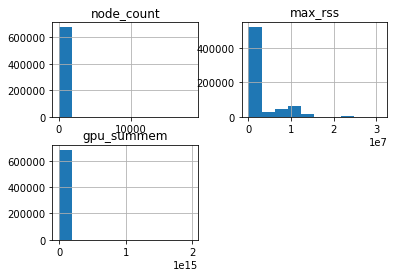

In [366]:
dfaux.drop([categories],1).hist()
plt.show()

/home/siserte/anaconda3/envs/mytf/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/siserte/anaconda3/envs/mytf/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/siserte/anaconda3/envs/mytf/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/siserte/anaconda3/envs/mytf/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/siserte/anaconda3/envs/mytf/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarn

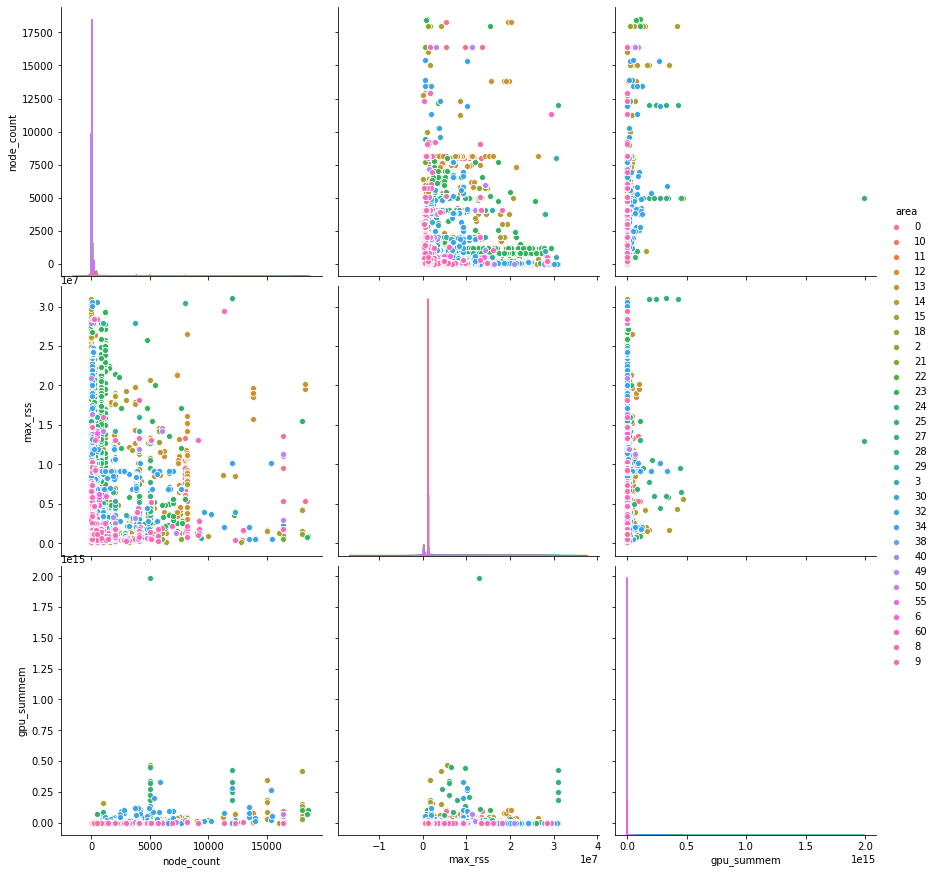

In [370]:
import seaborn as sb
sb.pairplot(dfaux.dropna(), hue=categories, height=4, vars=["node_count","max_rss","gpu_summem"],kind='scatter')

In [371]:
X = np.array(dfaux[["node_count","max_rss","gpu_summem"]])
y = np.array(dfaux[categories]).astype(int)
X.shape

(684382, 3)

<ipython-input-372-2ad503d55b39>:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


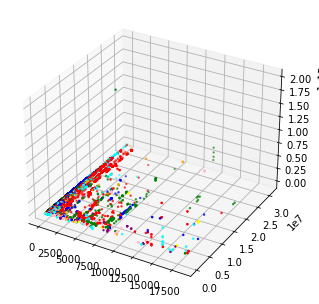

In [372]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink','brown','purple']
asignar=[]
for row in y:
    index = row%len(colores)
    asignar.append(colores[index])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=2)

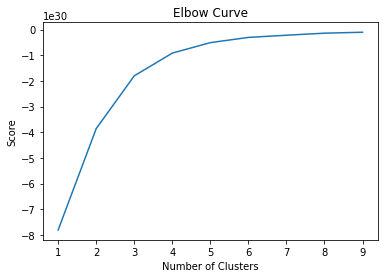

In [373]:
Nc = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [374]:
kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[5.91130677e+01 2.65067679e+06 1.02565068e+11]
 [9.20378947e+03 1.11805274e+07 3.23154438e+14]
 [5.00000000e+03 1.29781720e+07 1.98720218e+15]
 [7.82150825e+03 6.05115093e+06 5.64477402e+13]]


<ipython-input-376-f40d846ad2d7>:12: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


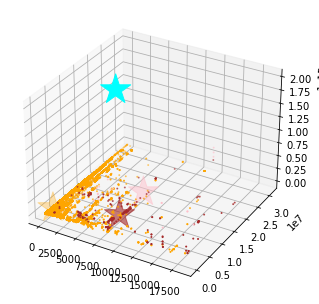

In [376]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['orange','pink','cyan', 'brown', 'purple']
colores=['orange','pink','cyan','brown']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=1)
#colores=['black','yellow']
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

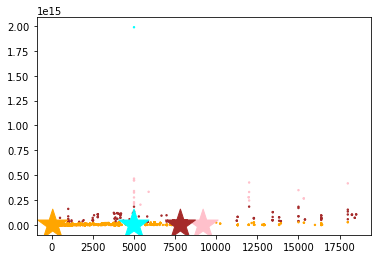

In [378]:
# Getting the values and plotting it
f1 = dfaux['node_count'].values
f2 = dfaux['gpu_summem'].values

plt.scatter(f1, f2, c=asignar, s=2)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

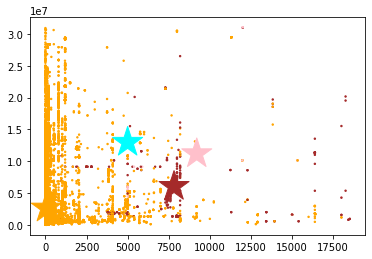

In [379]:
# Getting the values and plotting it
f1 = dfaux['node_count'].values
f2 = dfaux['max_rss'].values

plt.scatter(f1, f2, c=asignar, s=2)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

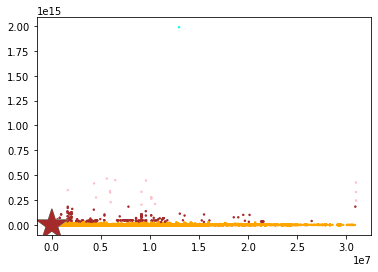

In [380]:
# Getting the values and plotting it
f1 = dfaux['max_rss'].values
f2 = dfaux['gpu_summem'].values

plt.scatter(f1, f2, c=asignar, s=2)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

In [381]:
copy =  pd.DataFrame()
copy['node_count']=dfaux['node_count'].values
copy[categories]=dfaux[categories].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,orange,684059
1,pink,19
2,cyan,1
3,brown,303
